<a href="https://colab.research.google.com/github/hertie-data-science-lab/tutorial-new-grp4/blob/main/DEEPL_Tutorial_xAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Explanability Methods for Machine- & Deep Learning
## GRAD-E1394 Deep Learning -- Assignment 3
Author(s):
*   Benjamin Adoba Ayida, 235194@students.hertie-school.org 
*   Padmavathi Narayana Reddy, 236167@students.hertie-school.org 
*   Luis Windpassinger, 241248@students.hertie-school.org 
*   Franco Bastida, 235549@students.hertie-school.org 

<Replace the information in this cell with a brief summary of the tutorial as well as users' expected learning outcomes.>
TODO


# Table of Contents


*   [Memo](#memo)
*   [Overview](#overview)
*   [Background & Prerequisites](#background-and-prereqs)
*   [Software Requirements](#software-requirements)
*   [Data Description](#data-description)
*   [Methodology](#methodology)
*   [Results & Discussion](#results-and-discussion)
*   [References](#references)


# General Guidelines
*(Please remove this and other guideline sections from your final tutorial submission.)*

This template should help you create your tutorial. You may introduce modifications and extensions but adhere to the general principles for writing the tutorial:

*   Be brief.
    *  Keep it short and simple. Avoid unnecessary complexity.
*   Clearly illustrate how the content relates to public policy.
    *  Identify the ways in which this tutorial would help the users (your collegues) in their work.
*   Provide enough context.
    *  Explain important concepts directly in the tutorial notebook, but feel free to direct users to external resources when necessary.  
*   Avoid or minimize the use of jargon.
    *  Ideally, the content can be understood by both an ML audience and by people who are relatively new to ML and deep learning.
*   Focus on readability and usability.
    *  Interleave code cells with explanatory text, keeping your audience in mind.
*   Follow guidelines to avoid plagiarism.
    * Any verbatim text needs to be put in quotation marks.
    * Do not copy code.
    * Clearly reference ideas and work of others.
    * [Hertie School Code of Conduct](https://hertieschool-f4e6.kxcdn.com/fileadmin/5_WhoWeAre/Code_of_Conduct.pdf)
* Ensure reproducibility.
    * Ensure that your notebook can be rerun by somebody else on a different machine in a reasonable amount of time. If the task is computationally expensive, provide an additional, smaller data sample for fast reproduction, and use that in your tutorial.

## Additional Instructions
We highly recommend that you follow the [Ten simple rules for writing and sharing computational analyses using Jupyter Notebooks](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007007). We summarize the ten rules as follows:

<center><img src="https://journals.plos.org/ploscompbiol/article/figure/image?size=large&id=info:doi/10.1371/journal.pcbi.1007007.g001" width=400>

<small>Rule, Adam, et al. "Ten simple rules for writing and sharing computational analyses in Jupyter Notebooks." PLoS computational biology 15.7 (2019).</small></center>

### Rule 1: Tell a story for an audience
* Interleave explanatory text and code to tell a compelling story.
* Describe not just what you did but why you did it.
* How you tell your story depends on your goal and your audience.

### Rule 2: Document the process, not just the results
* Document relevant interactive explorations.
* Don't wait until the end to add explanatory text.
* Generate publication-ready version of figures from the get-go.

### Rule 3: Use cell divisions to make steps clear
* Each cell should perform one meaningful step in the analysis.
* Think one cell = one paragraph, function, or task (e.g. creating a plot).
* Avoid long cells (50+ lines)
* Organize your notebook into sections/subsections.  

### Rule 4: Modularize code
* Avoid duplicate code (no copy-pasting!)
* Wrap the code that you want to reuse in a function.
* Use descriptive and meaningful variable and function names.

### Rule 5: Record dependencies
* Manage your dependencies using a package or environment manager (e.g. pip,conda)
* Feel free to use tools like Binder or Docker to generate a "container" for better reproducibility.

### Rule 6: Use version control
- Google colab allows you to view revision history.
- You can also opt to use Git and Github for version control.
- As Jupyter uses JSON for serialization, tracking raw changes on GitHub is difficult. [ReviewNB](https://www.reviewnb.com/) and [nbdime](https://github.com/jupyter/nbdime) can help to generate human-readable diffs.

### Rule 7: Build a pipeline
* A well-designed notebook can be generalized into a pipeline.
* Place key variable declarations at the top/beginning of the notebook.
* Make a habit of regularly restarting your kernel and rerunning all cells.
* Before submitting, reinstall all dependencies and rerun all cells in a new enviroment to ensure reproducibility.

### Rule 8: Share and explain your data
* Properly reference the data you use.
* If using your own data, make your data or a sample of your data publicly available along with the notebook.
* You can opt to host public copies of your data.

### Rule 9: Design your notebooks to be read, run, and explored
* Read: For code hosted in a public repository, add README and LICENSE files.
* Run: Consider using Google Colab, Binder, or Docker for seamless replication.
* Explore: Consider how you can design your notebook so future users can built on top of your work.

### Rule 10: Advocate for open research

<a name="memo"></a>
# Memo

Write a memo for the leadership explaining in layman's terms why this topic is relevant for public policy. Discuss relevant research works, real-world examples of successful applications, and/or organizations and governments that apply such approaches for policy making.




<a name="overview"></a>
# Overview

In this section, provide a summary of the main contributions of the tutorial notebook. Note that the tutorial should introduce or demonstrate the use of a method, dataset, tool, or technology to address a problem related to public policy. Be clear on the goal of the tutorial and the expected learning outcomes for the users.


<a name="background-and-prereqs"></a>
# Background & Prerequisites

You will need to specify the prerequisites and basic knowledge required for the tutorial. Afterwards, please provide a brief explanation of the most important concepts necessary for the users to follow the tutorial.

## Reading materials
Please include additional resources (e.g. research papers, blog posts, textbooks) for the readers to further study the topic of your tutorial.


<a name="software-requirements"></a>
# Software Requirements
Include in this section the software requirements, setup instructions, and library imports.

Example:

This notebook requires Python >= 3.7. The following libraries are required:
*   pandas
*   numpy
*   matplotlib

In [7]:
!pip install pandas numpy matplotlib scikit-learn torch seaborn ucimlrepo

  Using cached ucimlrepo-0.0.7-py3-none-any.whl.metadata (5.5 kB)
Using cached ucimlrepo-0.0.7-py3-none-any.whl (8.0 kB)


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

In [3]:
SEED = 123

# Dataset
<a name="data-description"></a>

<In this section, kindly provide a brief description of the dataset that you will use in this tutorial. Specify information such as the data type or file format (e.g. text, image, video, tabular), size, spatial resolution, temporal resolution, labels or categories, etc. Explicitly name the source of your dataset. If you are introducing a new dataset, feel free to include additional information (e.g. field survey sampling methods, dataset annotation efforts, etc.) or provide external links and resources that discuss the specific details of the dataset.> TODO

- Source: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data


## Data Download
Provide instructions on how to retrieve the necessary data.

This may include bash scripts, Python scripts, or other means of downloading the data.

In [22]:
# archive note: we first attempted to use this data set but opted to change to the German Credit Data Statlog

# we use this as it is nicely prepared (numerical recoding)
# url = "https://raw.githubusercontent.com/rajasekarsr/Credit_Risk_Prediction_DataAnalysis/refs/heads/master/DATA/index.csv"
# df = pd.read_csv(url)

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets

df = pd.concat([X, y], axis=1)

### Features

| Variable Name | Type        |  Description                                          | Units  | Missing Values |
|---------------|-----------|-----------------------------------------------------|-------|----------------|
| Attribute1    | Categorical | Status of existing checking account                 |       | no             |
| Attribute2    | Integer     | Duration                                             | months | no             |
| Attribute3    | Categorical | Credit history                                      |       | no             |
| Attribute4    | Categorical | Purpose                                             |       | no             |
| Attribute5    | Integer     | Credit amount                                       |       | no             |
| Attribute6    | Categorical | Savings account/bonds                               |       | no             |
| Attribute7    | Categorical | Present employment since                             |       | no             |
| Attribute8    | Integer     | Installment rate in percentage of disposable income |       | no             |
| Attribute9    | Categorical | Personal status and sex                           |       | no             |
| Attribute10   | Categorical | Other debtors / guarantors                           |       | no             |
| Attribute11   | Integer     | Present residence since                              |       | no             |
| Attribute12   | Categorical | Property                                            |       | no             |
| Attribute13   | Integer     | Age                                                 | years  | no             |
| Attribute14   | Categorical | Other installment plans                              |       | no             |
| Attribute15   | Categorical | Housing                                             |       | no             |
| Attribute16   | Integer     | Number of existing credits at this bank             |       | no             |
| Attribute17   | Categorical | Job                                                 |       | no             |
| Attribute18   | Integer     | Number of people being liable to provide maintenance for |   | no             |
| Attribute19   | Binary      | Telephone                                          |       | no             |
| Attribute20   | Binary      | foreign worker                                     |       | no             |

More information about each features' categories and definitions can be found [here](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data).

## Preprocessing

### Renaming

For the purpose of teaching and interpretability, we will provide meaningful names to the features below.

In [5]:
df = df.rename(columns={
    "Attribute1": "checking_acct",
    "Attribute2": "duration_months",
    "Attribute3": "credit_history",
    "Attribute4": "purpose",
    "Attribute5": "credit_amount",
    "Attribute6": "savings_acct",
    "Attribute7": "employment_since",
    "Attribute8": "installment_rate",
    "Attribute9": "personal_status_sex",
    "Attribute10": "debtors",
    "Attribute11": "residence_since",
    "Attribute12": "property",
    "Attribute13": "age",
    "Attribute14": "installment_plans",
    "Attribute15": "housing",
    "Attribute16": "existing_credits",
    "Attribute17": "employment",
    "Attribute18": "maintenance_people",
    "Attribute19": "telephone",
    "Attribute20": "foreign_worker",
    "class": "target" # 1 being good, 2 being bad
})

We want to explicitly check how many targets are "Good" vs. "Bad" for creditability purposes, since this can influence the majority class of any prediction. If it is, we will have to use a weighted loss for the distribution.

In [6]:
print(y.value_counts())
print(y.value_counts(normalize=True))

class
1        700
2        300
Name: count, dtype: int64
class
1        0.7
2        0.3
Name: proportion, dtype: float64


We want to explicitly check how many targets are "Good" vs. "Bad" for creditability purposes, since this can influence the majority class of any prediction. If it is, we will have to use a weighted loss for the distribution.

### One-Hot-Encoding

We need to One-Hot-Encode non-ordinal numerical category columns.

In [7]:
df["target"] = df["target"].replace({1: 0, 2: 1}).astype(float)
X = df.drop(columns=["target"])
y = df["target"]

In [9]:
X_ohe = pd.get_dummies(X, drop_first=True)
X_ohe = X_ohe.astype(float) # convert to numerical values for torch-compatability
X_ohe.head()

,duration_months,credit_amount,installment_rate,residence_since,age,existing_credits,maintenance_people,checking_acct_A12,checking_acct_A13,checking_acct_A14,...,property_A124,installment_plans_A142,installment_plans_A143,housing_A152,housing_A153,employment_A172,employment_A173,employment_A174,telephone_A192,foreign_worker_A202
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


### Data splitting

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=SEED)

In [42]:
# check for equal size
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

800 800
200 200


In [43]:
X_train.head()

,duration_months,credit_amount,installment_rate,residence_since,age,existing_credits,maintenance_people,checking_acct_A12,checking_acct_A13,checking_acct_A14,...,property_A124,installment_plans_A142,installment_plans_A143,housing_A152,housing_A153,employment_A172,employment_A173,employment_A174,telephone_A192,foreign_worker_A202
512,15.0,2687.0,2.0,4.0,26.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
685,60.0,6527.0,4.0,4.0,34.0,1.0,2.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
997,12.0,804.0,4.0,4.0,38.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
927,48.0,10297.0,4.0,4.0,39.0,3.0,2.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
376,18.0,2320.0,2.0,3.0,34.0,2.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [44]:
X_test_orig = X_test.copy()

## Exploratory Data Analyis

In [45]:
df.head(5)

,checking_acct,duration_months,credit_history,purpose,credit_amount,savings_acct,employment_since,installment_rate,personal_status_sex,debtors,...,property,age,installment_plans,housing,existing_credits,employment,maintenance_people,telephone,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0.0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1.0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0.0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0.0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1.0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   checking_acct        1000 non-null   object 
 1   duration_months      1000 non-null   int64  
 2   credit_history       1000 non-null   object 
 3   purpose              1000 non-null   object 
 4   credit_amount        1000 non-null   int64  
 5   savings_acct         1000 non-null   object 
 6   employment_since     1000 non-null   object 
 7   installment_rate     1000 non-null   int64  
 8   personal_status_sex  1000 non-null   object 
 9   debtors              1000 non-null   object 
 10  residence_since      1000 non-null   int64  
 11  property             1000 non-null   object 
 12  age                  1000 non-null   int64  
 13  installment_plans    1000 non-null   object 
 14  housing              1000 non-null   object 
 15  existing_credits     1000 non-null   in

Key dataset characteristics:

- 1000 rows
- 20 features (some numerical, some categorical)
- 1 class: "creditability", i.e. credit-worthiness (1 = Good, 2 = Bad)
- No missing values

### Distribution

The below code will generate a distribution plot per feature. If you want to understand what each value on the x axis of the plot means (if it is not numerical), please refer to the dataset [documentation](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data) .

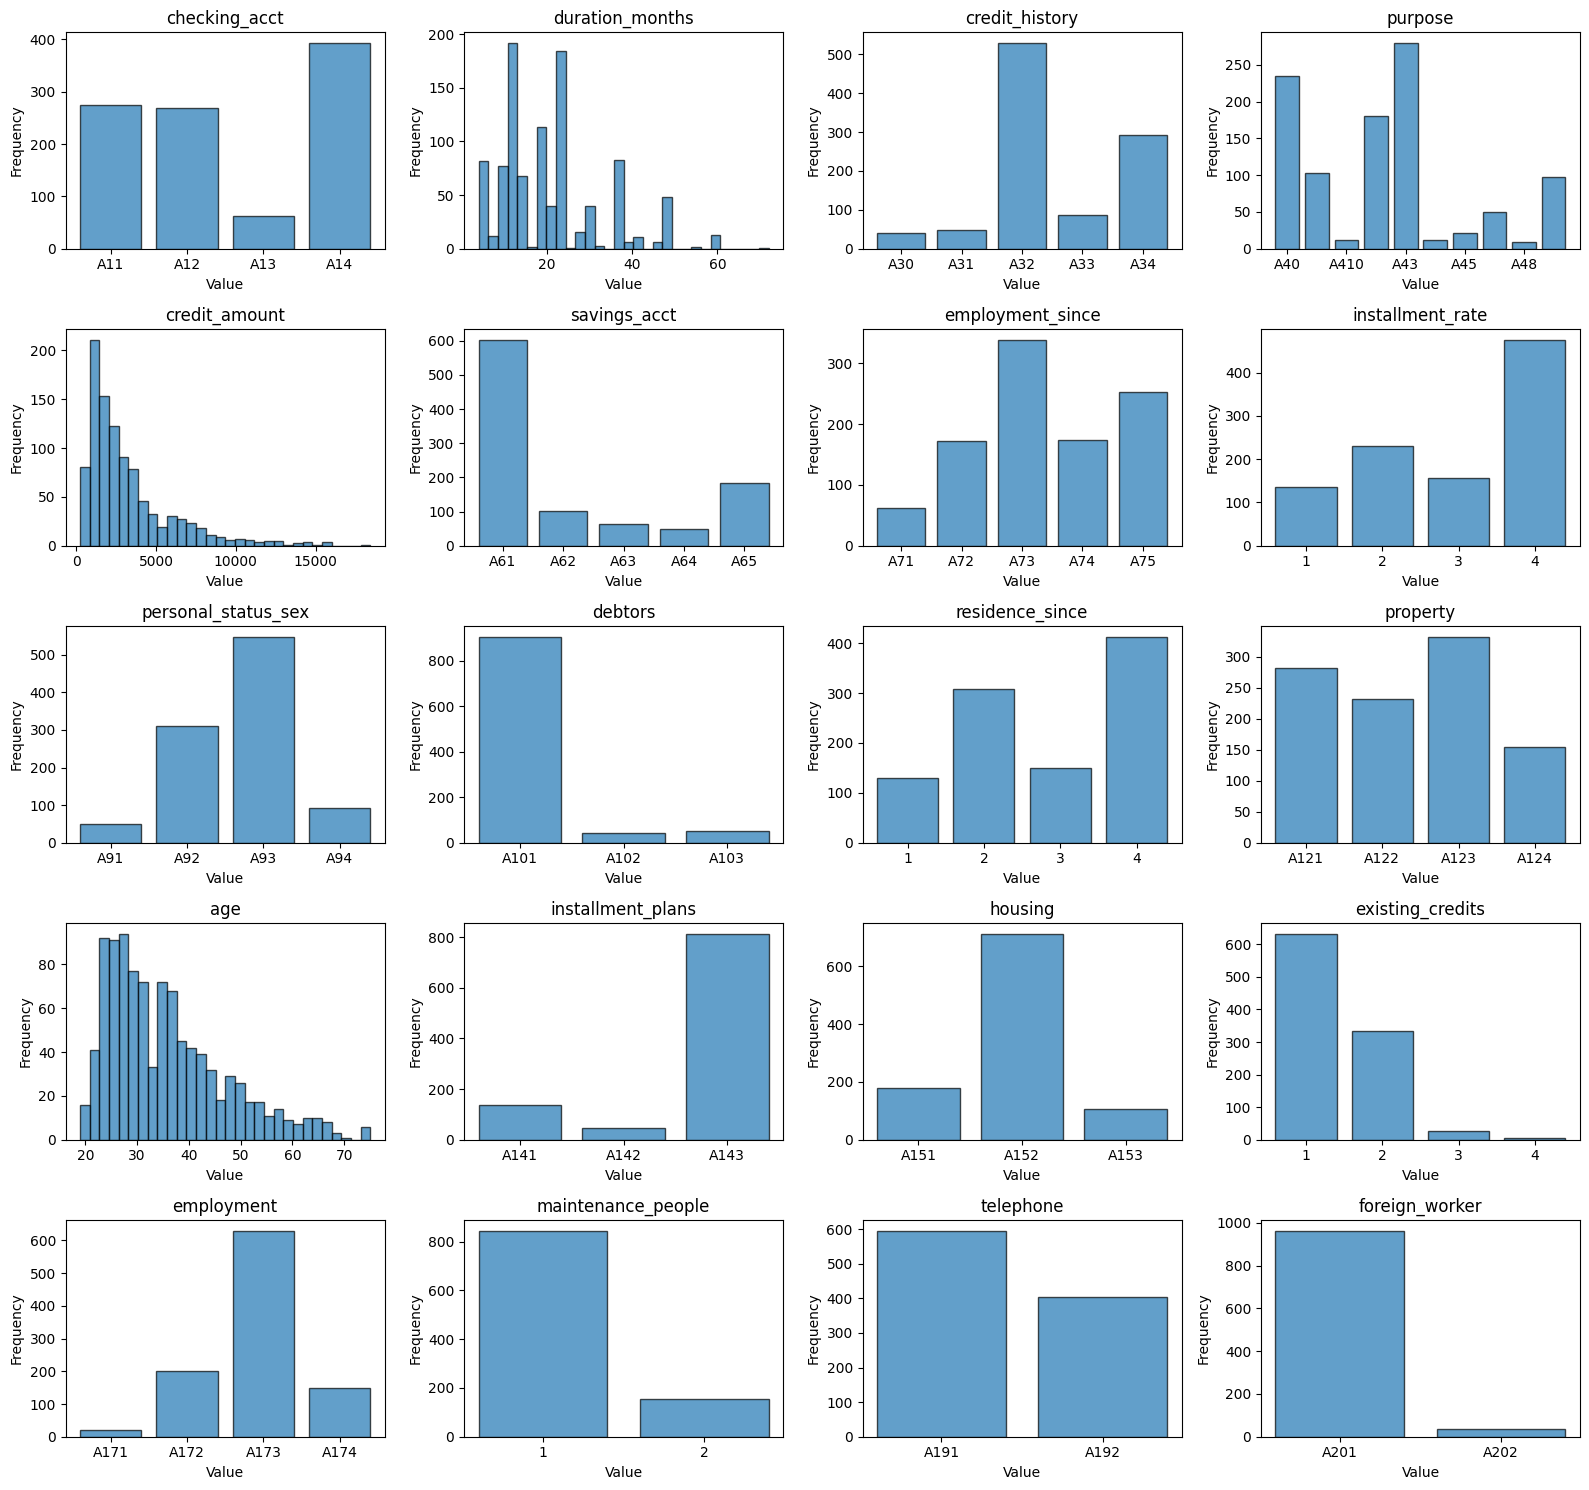

In [47]:
from matplotlib.ticker import MaxNLocator

num_features = X.shape[1]
ncols = 4
nrows = int(np.ceil(num_features / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
axes = axes.flatten()

for idx, col in enumerate(X.columns):
    ax = axes[idx]
    # Check if column is categorical (object or bool)
    if X[col].dtype == 'object' or X[col].dtype == 'bool' or X[col].nunique() < 20:
        counts = X[col].value_counts().sort_index()
        ax.bar(counts.index.astype(str), counts.values, edgecolor='black', alpha=0.7)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    else:
        ax.hist(X[col], bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Remove unused axes
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


TODO briefly summarize some observations

### Correlation of features & target

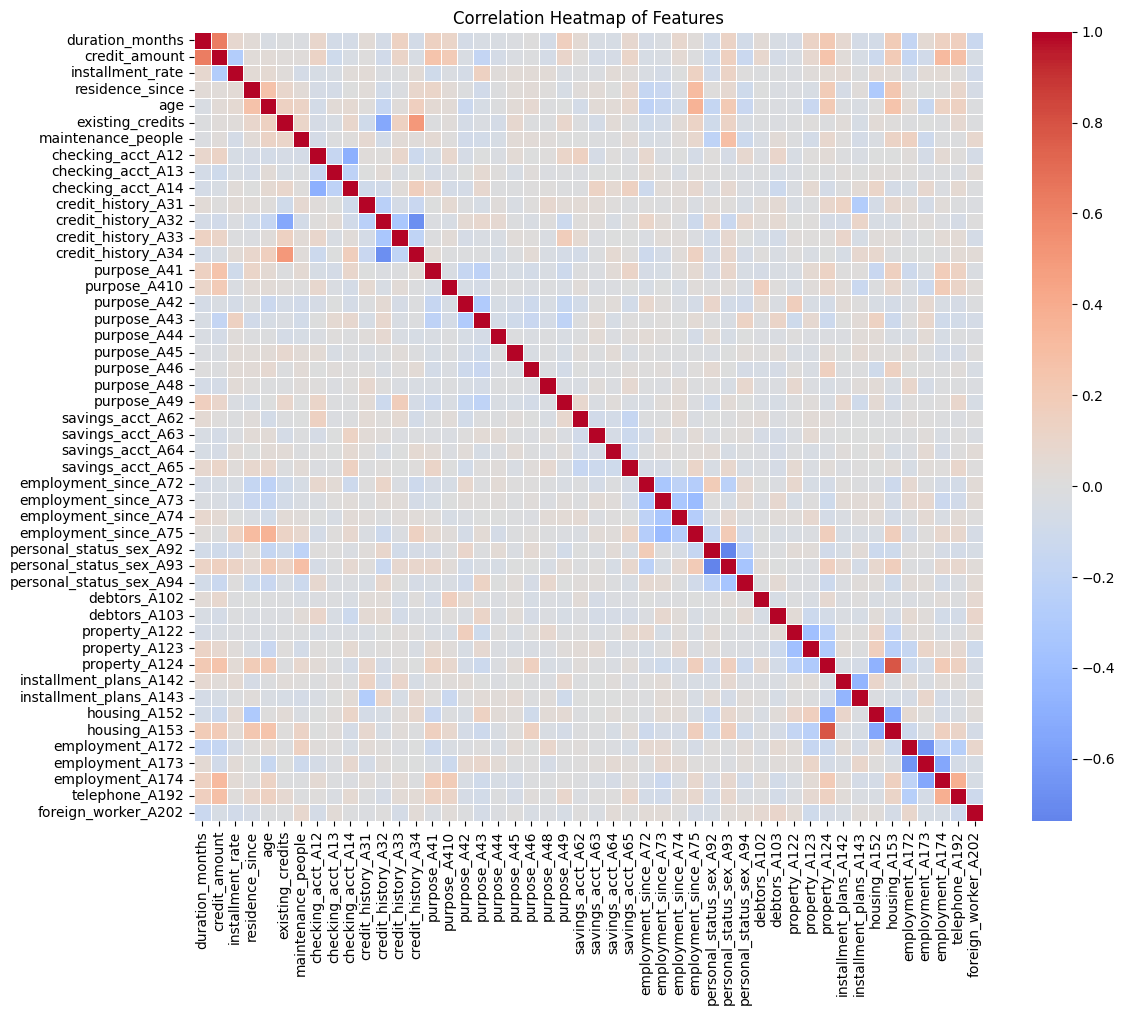

In [48]:
# Calculate correlation matrix
correlation_matrix = X_ohe.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()

**The top 10 most correlated features**

In [49]:
corr_pairs = correlation_matrix.abs().unstack()
corr_pairs = corr_pairs[corr_pairs < 1]  # remove self-correlation
corr_pairs = corr_pairs.sort_values(ascending=False)

corr_pairs = corr_pairs.drop_duplicates()

corr_pairs.head(10)

housing_A153             property_A124              0.779853
personal_status_sex_A93  personal_status_sex_A92    0.738036
credit_history_A32       credit_history_A34         0.683617
employment_A173          employment_A172            0.652438
duration_months          credit_amount              0.624984
housing_A153             housing_A152               0.548445
employment_A173          employment_A174            0.543852
credit_history_A32       existing_credits           0.540354
existing_credits         credit_history_A34         0.501364
checking_acct_A12        checking_acct_A14          0.489136
dtype: float64

TODO Describe which features correlate most

# Sanity Check: Balance of Target Values, "Creditability"

Seeing how our classes are imbalanced, with the majority (70%) being “Good”, we will have to adjust the loss function to modify the weights. 

*`BCEWithLogitsLoss`* in [PyTorch Documentation](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) can help us do just that. The BCE loss is:

$
\ell = - \left[\, y \cdot \log(\sigma(x)) \;+\; (1 - y)\cdot \log(1 - \sigma(x)) \,\right]
$

...where

* $x$ = model output logit  
* $\sigma(x)$ = sigmoid applied to the logit (gives a probability between 0 and 1)  
* $y \in \{0,1\}$ = true label  

This means that depending on the probability of class 1, we can penalize the model for giving low or high probability. 

If y = 1, we punish the model when sigma is small. If y = 0, we punish the model when sigma is large. In this case, it's the second. To calculate this, we can refer to the documentation to apply  *`pos_weight`*. The example states that in a dataset containing 100 positive and 300 negative examples of a single class, the positive weight of the class is equal to...

$
\text{pos\_weight} = \frac{\text{num\_negative}}{\text{num\_positive}}
\quad\Rightarrow\quad
\text{pos\_weight} = \frac{\text{300}}{\text{100}}
\quad\Rightarrow\quad
\text{pos\_weight} = \text{3}
$

In our case this is...

$
\text{pos\_weight} = \frac{\text{700}}{\text{300}}
\quad\Rightarrow\quad
\text{pos\_weight} = \text{2.33}
$

In [50]:
import torch.nn as nn

pos_weight = torch.tensor([700/300])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Modeling: Neural Network

For this part, we are training a base feed-forward neural network, which is a straightforward model to handle tabular data such as ours. By this, we will have the following structure:

*   **Input**: 20 features  
*   **Hidden layer 1**: (H1): 64 neurons (ReLU)  
*   **Hidden layer 2**: 32 neurons (ReLU)  
*   **Output**: 1 neuron (sigmoid), appropriate for the binary classification

In this, FFNN (Multilayer Perceptron), H1 learns the combinations of input features, while H2 learns the patterns underlying these combinations, and the output provides the class probability of creditability = 1.

Note: We are using PyTorch, which is more practical and reliable instead of a hard-coded architecture from scratch.

In [62]:
from torch.utils.data import TensorDataset, DataLoader

#The base FFNN
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(), #h1 activation
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(), #h2 activation
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(), #h3 activation
            nn.Dropout(0.2),

            nn.Linear(32, 1) #logit
        )  

    def forward(self, x):
        return self.net(x)

In [63]:
#We convert the df to tensors to be able to train with PyTorch
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
X_test_t  = torch.tensor(X_test.values, dtype=torch.float32)

y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

#Sanity check of labels
print(y_train_t.unique())
print(y_test_t.unique())

#Sanity check of long
print(y_train_t.dtype)
print(y_test_t.dtype)

tensor([0., 1.])
tensor([0., 1.])
torch.float32
torch.float32


In [64]:
FFNN_model = MLP(X_train.shape[1])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(FFNN_model.parameters(), lr=1e-3) #standard lr

epochs = 50 #default used in other exercises

for xb, yb in train_dl:
    print("xb:", xb.shape)  # should be [32, num_features]
    print("yb:", yb.shape)  # should be [32]
    break

for epoch in range(epochs):
  FFNN_model.train()
  epoch_loss = 0

  for xb, yb in train_dl:
    optimizer.zero_grad()

    logits = FFNN_model(xb)
    loss = criterion(logits, yb)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f}")

xb: torch.Size([64, 48])
yb: torch.Size([64, 1])
Epoch 1 | Loss: 125.2714
Epoch 2 | Loss: 55.0958
Epoch 3 | Loss: 31.5595
Epoch 4 | Loss: 21.1304
Epoch 5 | Loss: 16.7373
Epoch 6 | Loss: 19.2603
Epoch 7 | Loss: 15.6085
Epoch 8 | Loss: 14.1715
Epoch 9 | Loss: 14.3223
Epoch 10 | Loss: 13.9013
Epoch 11 | Loss: 13.9936
Epoch 12 | Loss: 13.2878
Epoch 13 | Loss: 13.0270
Epoch 14 | Loss: 13.0658
Epoch 15 | Loss: 13.3790
Epoch 16 | Loss: 13.2715
Epoch 17 | Loss: 13.0568
Epoch 18 | Loss: 13.0320
Epoch 19 | Loss: 12.9108
Epoch 20 | Loss: 12.7162
Epoch 21 | Loss: 12.7651
Epoch 22 | Loss: 12.6627
Epoch 23 | Loss: 12.6354
Epoch 24 | Loss: 13.0964
Epoch 25 | Loss: 12.5642
Epoch 26 | Loss: 12.6925
Epoch 27 | Loss: 12.6380
Epoch 28 | Loss: 12.7141
Epoch 29 | Loss: 12.8118
Epoch 30 | Loss: 12.4963
Epoch 31 | Loss: 12.6602
Epoch 32 | Loss: 12.7544
Epoch 33 | Loss: 12.6691
Epoch 34 | Loss: 12.7143
Epoch 35 | Loss: 12.6569
Epoch 36 | Loss: 12.5991
Epoch 37 | Loss: 12.9118
Epoch 38 | Loss: 12.7478
Epoch 39 

In [65]:
#Accuracy Evaluation
FFNN_model.eval()
with torch.no_grad():
    logits = (FFNN_model(X_test_t)) 
    probs = torch.sigmoid(logits)
    pred = (probs >= 0.5).float() 

    pred_np = pred.squeeze(1).cpu().numpy()
    y_test_np = y_test_t.squeeze(1).cpu().numpy()

  

In [66]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_test_np = y_test_t.cpu().numpy()

# ----- FFNN / MLP -----
print("\n Feed-Forward Neural Network Results")
print("--------------------------------------")
print("FFNN Test Accuracy:", accuracy_score(y_test_np, pred_np))
print("\nFFNN Classification Report:\n", classification_report(y_test_np, pred_np))
print("FFNN Confusion Matrix:\n", confusion_matrix(y_test_np, pred_np))


 Feed-Forward Neural Network Results
--------------------------------------
FFNN Test Accuracy: 0.635

FFNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.73      0.74       139
         1.0       0.40      0.41      0.41        61

    accuracy                           0.64       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.64      0.64      0.64       200

FFNN Confusion Matrix:
 [[102  37]
 [ 36  25]]


This dataset requires use of a cost matrix (see below):

|        | Predicted 1 | Predicted 2 |
|--------|-------------|-------------|
| True 1 | 0           | 1           |
| True 2 | 5           | 0           |

*(1 = Good, 2 = Bad)*

It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1).

# SHAP Implementation

# Lime Implementation

# Causal

In [1]:
!pip install dice-ml

   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 2.5/2.5 MB 18.1 MB/s  0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 15.2 MB/s  0:00:00
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   --- ------------------------------------ 6.3/72.0 MB 32.1 MB/s eta 0:00:03
   -------- ------------------------------- 14.7/72.0 MB 36.9 MB/s eta 0:00:02
   ------------ --------------------------- 22.0/72.0 MB 35.7 MB/s eta 0:00:02
   ----------------- ---------------------- 30.7/72.0 MB 37.4 MB/s eta 0:00:02
   ------------------ --------------------- 33.8/72.0 MB 33.6 MB/s eta 0:00:02
   ---------------------- ----------------- 40.1/72.0 MB 31.9 MB/s eta 0:00:01
   -------------------------- ------------- 46.9/72.0 MB 31.8 MB/s eta 0:00:01
   ----------------------------- ---------- 53.0/72.0 MB 31.5 MB/s eta 0:00:01
   ----------

In [35]:
#libraries required to explore dice method for "what-if counterfactual analysis"
from dice_ml import Dice
import numpy as np
import pandas as pd

In [71]:
#Using DICE model for counterfactual analysis

# Create df_for_dice from original dataset before hot-encoding
df_for_dice = pd.concat([X_ohe, y], axis=1)

# Define continuous features
continuous_features = [
    'duration_months',
    'credit_amount',
    'installment_rate',
    'residence_since',
    'age',
    'existing_credits',
    'maintenance_people'
]

# Create DiCE data object
d = dice_ml.Data(
    dataframe=df_for_dice,
    continuous_features=continuous_features,
    outcome_name='target'
)

# Model wrapper required for dice
class PyTorchWrapper:
    def __init__(self, model, feature_names):
        self.model = model
        self.feature_names = feature_names
    
    def predict(self, X):
        """Predict class labels"""
        probs = self.predict_proba(X)
        return (probs[:, 1] > 0.5).astype(int)
    
    def predict_proba(self, X):
        """Predict class probabilities - requied by DiCE"""
        self.model.eval()
        if isinstance(X, pd.DataFrame):
            X_ohe = pd.get_dummies(X, drop_first=True)
            X_ohe = X_ohe.reindex(columns=self.feature_names, fill_value=0)
        else:
            X_ohe = X
            
        X_tensor = torch.FloatTensor(X_ohe.values)
        with torch.no_grad():
            logits = self.model(X_tensor)
            probs = torch.sigmoid(logits).numpy()
        
        # Return probabilities for both classes [P(class=0), P(class=1)]
        return np.hstack([1 - probs, probs])

wrapped_model = PyTorchWrapper(FFNN_model, X_ohe.columns.tolist())
dice_model = dice_ml.Model(model=wrapped_model, backend='sklearn', model_type='classifier')
exp = Dice(d, dice_model, method='random')



In [ ]:
# Analyse rejected applications
rejected_indices = np.where(pred_np == 1)[0]

print(f"Counterfactual analysis for rejected applications: {len(rejected_indices)}")

if len(rejected_indices) > 0:
    # Sort rejected cases by rejection probability (descending)
    rejected_probs = probs_test[rejected_indices]
    sorted_idx = rejected_indices[np.argsort(-rejected_probs)]

    # Number of rejected applications we want to inspect
    No_of_examples = 3   # change to 5 if you want top 5

    features_to_vary = ['duration_months', 'credit_amount', 'installment_rate', 'age']

    for ex_no, example_idx in enumerate(sorted_idx[:No_of_examples], start=1):
        query_instance = X_test_orig.iloc[[example_idx]]

        print(f"EXAMPLE {ex_no} – Rejected application (Test Index #{example_idx})")
        print(f"Rejection probability: {probs_test[example_idx]:.2%}")

        # ---- Original application details ----
        print("\nOriginal application:")
        display_features = {
            'checking_acct': 'Checking Account',
            'duration_months': 'Loan Duration (months)',
            'credit_amount': 'Loan Amount ($)',
            'installment_rate': 'Installment Rate (%)',
            'age': 'Age (years)',
            'existing_credits': 'Existing Credits'
        }

        for col, label in display_features.items():
            if col in query_instance.columns:
                value = query_instance[col].values[0]
                print(f"  {label:30s}: {value}")

        try:
            # ---- Generate counterfactuals for this application ----
            dice_exp = exp.generate_counterfactuals(
                query_instance,
                total_CFs=3,          # 3 counterfactuals
                desired_class=0,      # Want approval
                features_to_vary=features_to_vary,
                permitted_range={
                    'age': [18, 75],
                    'credit_amount': [250, 20000],
                    'duration_months': [4, 72],
                    'installment_rate': [1, 4]
                }
            )

            cf_df = dice_exp.cf_examples_list[0].final_cfs_df

            print("\nChanges needed for approval:\n")

            if cf_df is None or len(cf_df) == 0:
                print("  (No valid counterfactuals found for this case.)")
                continue

            # - summary: only changed features ----
            for i in range(len(cf_df)):
                cf_row = cf_df.iloc[i]
                print(f"  Counterfactual {i+1}:")

                changes_found = False
                for feat in features_to_vary:
                    if feat in query_instance.columns and feat in cf_row.index:
                        orig_val = query_instance[feat].values[0]
                        new_val = cf_row[feat]

                        # Only show if actually different
                        if pd.isna(orig_val) or pd.isna(new_val):
                            continue
                        if orig_val == new_val:
                            continue

                        changes_found = True
                        print(f"    - {feat:18s}: {orig_val} → {new_val}")

                
                print()  

        except Exception as e:
            print(f"\n❌ Error: {e}")
            import traceback
            traceback.print_exc()


Counterfactual analysis for rejected applications: 62
EXAMPLE 1 – Rejected application (Test Index #53)
Rejection probability: 61.43%

Original application:
  Loan Duration (months)        : 6.0
  Loan Amount ($)               : 14896.0
  Installment Rate (%)          : 1.0
  Age (years)                   : 68.0
  Existing Credits              : 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.99it/s]



Changes needed for approval:

  Counterfactual 1:
    - credit_amount     : 14896.0 → 3007.0
    -> resulting label: target = 0.0
    -> counterfactual target: 0.0

  Counterfactual 2:
    - credit_amount     : 14896.0 → 877.8
    - age               : 68.0 → 44.3
    -> resulting label: target = 0.0
    -> counterfactual target: 0.0

  Counterfactual 3:
    - credit_amount     : 14896.0 → 2610.9
    -> resulting label: target = 0.0
    -> counterfactual target: 0.0

EXAMPLE 2 – Rejected application (Test Index #13)
Rejection probability: 60.95%

Original application:
  Loan Duration (months)        : 36.0
  Loan Amount ($)               : 14318.0
  Installment Rate (%)          : 4.0
  Age (years)                   : 57.0
  Existing Credits              : 1.0


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]



Changes needed for approval:

  Counterfactual 1:
    - duration_months   : 36.0 → 6.9
    - credit_amount     : 14318.0 → 678.3
    -> resulting label: target = 0.0
    -> counterfactual target: 0.0

  Counterfactual 2:
    - credit_amount     : 14318.0 → 3376.9
    -> resulting label: target = 0.0
    -> counterfactual target: 0.0

  Counterfactual 3:
    - credit_amount     : 14318.0 → 3305.4
    - installment_rate  : 4.0 → 1.4
    -> resulting label: target = 0.0
    -> counterfactual target: 0.0

EXAMPLE 3 – Rejected application (Test Index #174)
Rejection probability: 60.86%

Original application:
  Loan Duration (months)        : 39.0
  Loan Amount ($)               : 14179.0
  Installment Rate (%)          : 4.0
  Age (years)                   : 30.0
  Existing Credits              : 2.0


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Changes needed for approval:

  Counterfactual 1:
    - credit_amount     : 14179.0 → 1656.3
    -> resulting label: target = 0.0
    -> counterfactual target: 0.0

  Counterfactual 2:
    - credit_amount     : 14179.0 → 1310.5
    -> resulting label: target = 0.0
    -> counterfactual target: 0.0

  Counterfactual 3:
    - credit_amount     : 14179.0 → 3313.8
    - installment_rate  : 4.0 → 2.3
    -> resulting label: target = 0.0
    -> counterfactual target: 0.0



# Limitations

Finally, include a discussion on the limitations and important takeaways from the exercise.
*   The tutorial is focused on education and learning. Explain all the simplifications you have made compared to applying a similar approach in the real world (for instance, if you have reduced your training data and performance).
*   ML algorithms and datasets can reinforce or reflect unfair biases. Reflect on the potential biases in the dataset and/or analysis presented in your tutorial, including its potential societal impact, and discuss how readers might go about addressing this challenge.

## Next Steps
*   What do you recommend would be the next steps for your readers after finishing your tutorial?
*   Discuss other potential policy- and government-related applications for the method or tool discussed in the tutorial.
*   List anything else that you would want the reader to take away as they move on from the tutorial.

<a name="references"></a>
# References



## Acknowledgement
